In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [ ]:
print(train_images.shape,test_images.shape)

(60000, 28, 28) (10000, 28, 28)


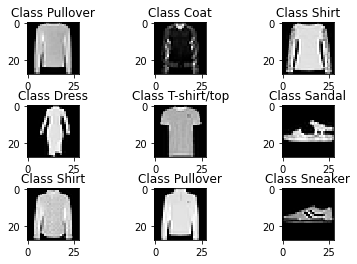

In [ ]:
# random check with nine training examples
np.random.seed(0);
indices = list(np.random.randint(train_images.shape[0],size=9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.subplots_adjust(hspace=0.6,wspace=0.6)
    plt.title("Class {}".format(class_names[train_labels[indices[i]]]))



### Prepare Pixel Data

We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

**Data**:
- The data are grayscale 28*28 images of scanned handwritten digits
- We will use an MLP to classify them so we first need to flatten them
- The values of the inputs are in [0, 255] so we normalize them to [0, 1]

In [ ]:
classes=len(np.unique(train_labels))
X_train = train_images.reshape(60000, 784)
X_test = test_images.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
y_train = keras.utils.to_categorical(train_labels, classes)
y_test = keras.utils.to_categorical(test_labels, classes)


### Define Evaluation metrics & Helper Functions

In [ ]:
import keras.backend as K

Using TensorFlow backend.


In [ ]:
from sklearn.metrics import *

In [ ]:
# for visualizing the training progress of our models
%matplotlib inline
import matplotlib.pyplot as plt
def viz_history(hs_dict,metric):
  plt.style.use('dark_background')
  plt.rcParams['figure.figsize'] = [15, 8]
  plt.rcParams['font.size'] = 16
  plt.clf()
  for model in hs_dict.keys():
    plt.plot(hs_dict[model].history[metric],label='{0:s} train {1:s}'.format(model, metric))
    plt.plot(hs_dict[model].history['val_{0:s}'.format(metric)],label='{0:s} validation {1:s}'.format(model, metric))
    plt.ylabel(metric) 
    plt.xlabel('epoch')
    plt.legend()
  plt.show()


In [ ]:
def print_results(hs,model,best_epoch=-1):
  print("Train Loss     : {0:.5f}".format(hs.history['loss'][best_epoch]))
  print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][best_epoch]))
  eval_model=model.evaluate(X_test, y_test, verbose=0)
  print("Test Loss: {0:.5f}".format(eval_model[0]))

 
  print('-------')
  print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][best_epoch]))
  print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][best_epoch]))
  print("Test Accuracy: {0:.5f}".format(eval_model[1]))
  # print('-------')
  # print("Train f1 score     : {0:.5f}".format(hs.history['f1'][-1]))
  # print("Validation f1 score: {0:.5f}".format(hs.history['val_f1'][-1]))



In [ ]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping

### General Function for creating MLP models

In [ ]:
model_params={'dropout':0.2,
              'hidden_units':128,
              'hidden_layers':1,
              'hidden_activation':'relu',
              'lr':0.001,
              'learning_rate':0.001,
              }

In [ ]:
def train_model(train_data,
                train_labels,
                model_params,
                optimizer=Adam,
                epochs=100,
                batch_size=128,
                ):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    tf.random.set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=(784,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    for i in range(model_params['hidden_layers']):
        x = Dense(
            units=model_params['hidden_units'],
            kernel_initializer='glorot_uniform',
            activation=model_params['hidden_activation'],
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        if model_params['dropout']:
          x = Dropout(
                rate=model_params['dropout'],
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
        
    # Define the output layer.
    output = Dense(
        units=10,
        kernel_initializer='uniform',
        activation='softmax',
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    if(optimizer==Adam):
      model.compile(optimizer=optimizer(model_params['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])

    else:
      model.compile(optimizer=optimizer(model_params['lr'],momentum=0.9,nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

    print('------------------')
    model.summary() # Print a description of the model.
    keras.utils.plot_model(model, to_file='model.png', show_shapes=True, dpi=50)
    
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                    patience=10,
                                    verbose=1,
                                    restore_best_weights=True
  )
    hs = model.fit(
        x=train_data,
        y=train_labels,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping],
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    # model.summary() # Print a description of the model.
    return model, hs


### Baseline model


* The baseline model will consist of three layers.

* The first layer will *flatten* the input, from 28x28 arrays to 1D arrays of 784 pixels.

* The second is densely-connected, or fully-connected, with 128 nodes (neurons), and ReLU for activation.

* The third is again dense, with 10 output nodes and softmax to yield the probabilities of an item belonging to each class.


In [ ]:
#call the baseline Model through the train function
base_model,base_hs=train_model(
    train_data=X_train,
    train_labels=y_train,
    optimizer=Adam,
    epochs=100,
    batch_size=128,
    model_params=model_params
)

------------------
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 128)               100480    
_________________________________________________________________
Dropout-1 (Dropout)          (None, 128)               0         
_________________________________________________________________
Output (Dense)               (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 2s 29us/step - loss: 0.6633 - accuracy: 0.7715 - val_loss: 0.4567 - val_accuracy: 0.8395
Epoch 2/100
54000/54000 [=========

In [ ]:
# Find the scores from the epochs according to Early stopping
best_epoch = np.argmax(base_hs.history['val_accuracy']) + 1
print('Best epoch=',best_epoch)
print('Best val_accuracy=',np.max(base_hs.history['val_accuracy']))

Best epoch= 26
Best val_accuracy= 0.8964999914169312


In [ ]:
#print results at last epoch
print_results(base_hs,base_model)

Train Loss     : 0.19439
Validation Loss: 0.32707
Test Loss: 0.32705
-------
Train Accuracy     : 0.92602
Validation Accuracy: 0.89350
Test Accuracy: 0.88930


In [ ]:
#print results at best epoch
print_results(base_hs,base_model,best_epoch=best_epoch-1)

Train Loss     : 0.22376
Validation Loss: 0.31224
Test Loss: 0.32705
-------
Train Accuracy     : 0.91576
Validation Accuracy: 0.89650
Test Accuracy: 0.88930


### Train baseline SGD


In [ ]:
#call the baseline Model through the train function
base_model_sgd,base_hs_sgd=train_model(
    train_data=X_train,
    train_labels=y_train,
    optimizer=SGD,
    epochs=100,
    batch_size=128,
    model_params=model_params
)

------------------
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 128)               100480    
_________________________________________________________________
Dropout-1 (Dropout)          (None, 128)               0         
_________________________________________________________________
Output (Dense)               (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 1s 25us/step - loss: 1.6336 - accuracy: 0.5170 - val_loss: 1.0602 - val_accuracy: 0.6750
Epoch 2/100
54000/54000 [==========

In [ ]:
#print results at last epoch
print_results(base_hs_sgd,base_model_sgd)

Train Loss     : 0.32471
Validation Loss: 0.33625
Test Loss: 0.36317
-------
Train Accuracy     : 0.88622
Validation Accuracy: 0.88017
Test Accuracy: 0.86990


In [ ]:
#print results at best epoch
print_results(base_hs_sgd,base_model_sgd)

Train Loss     : 0.32471
Validation Loss: 0.33625
Test Loss: 0.36317
-------
Train Accuracy     : 0.88622
Validation Accuracy: 0.88017
Test Accuracy: 0.86990


### Visualize Results

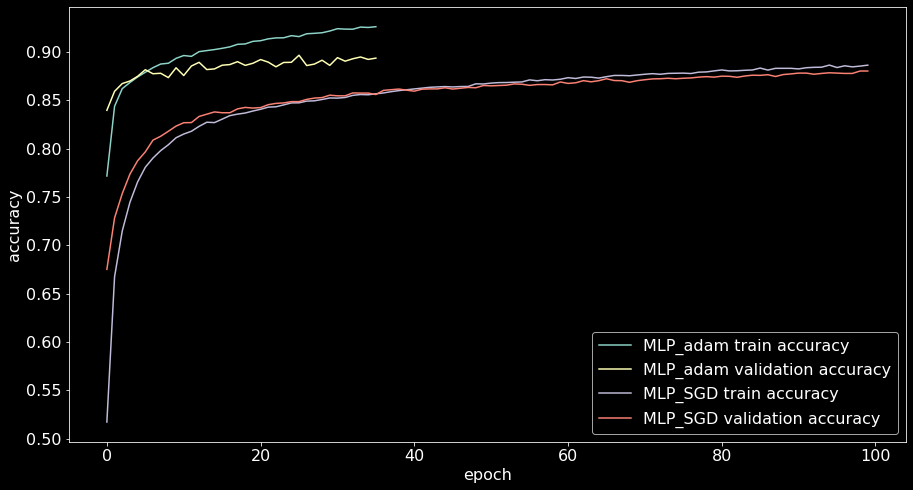

In [ ]:
viz_history(hs_dict={'MLP_adam':base_hs,'MLP_SGD':base_hs_sgd},metric='accuracy')


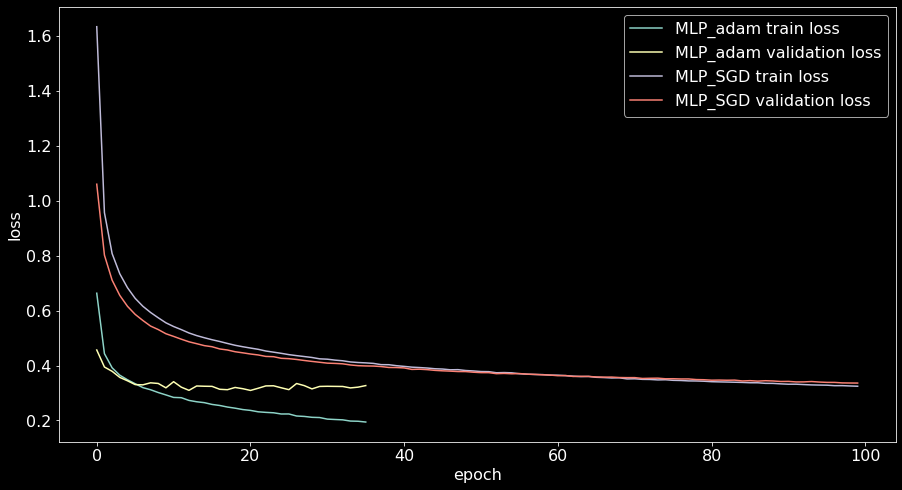

In [ ]:
viz_history(hs_dict={'MLP_adam':base_hs,'MLP_SGD':base_hs_sgd},metric='loss')


### MLP Fine Tuning

In [ ]:
!pip install keras-tuner

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
model_params.keys()

dict_keys(['dropout', 'hidden_units', 'hidden_layers', 'hidden_activation', 'lr', 'learning_rate'])

In [ ]:

def tune_mlp_adam(hp):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    # tf.random.set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = tf.keras.Input(
        shape=(784,),
        name='Input'
    )

    x = input
    hp_units = hp.Choice('hidden_units',values=[256])
    hp_hidden_layers=hp.Choice('hidden_layers',values=[1,2])
    hp_hidden_activation=hp.Choice('hidden_activation',values=['relu'])
    hp_dropout=hp.Choice('dropout',values=[0.2,0.5])
    # Define the remaining hidden layers.
    for i in range( hp_hidden_layers):
        x = tf.keras.layers.Dense(
            units=hp_units,
            kernel_initializer='glorot_uniform',
            activation=hp_hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        x = tf.keras.layers.Dropout(
              rate=hp_dropout,
              name='Dropout-{0:d}'.format(i + 1)
          )(x)
        
    # Define the output layer.
    output = tf.keras.layers.Dense(
        units=10,
        kernel_initializer='uniform',
        activation='softmax',
        name='Output'
    )(x)

    # Define the model and train it.
    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3)),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

    #print('------------------')
    #model.summary() # Print a description of the model.

   # model.summary() # Print a description of the model.
    return model

In [ ]:
def tune_mlp_sgd(hp):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    # tf.random.set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = tf.keras.Input(
        shape=(784,),
        name='Input'
    )

    x = input
    hp_units = hp.Choice('hidden_units',values=[256])
    hp_hidden_layers=hp.Choice('hidden_layers',values=[1,2])
    hp_hidden_activation=hp.Choice('hidden_activation',values=['relu'])
    hp_dropout=hp.Choice('dropout',values=[0.2])
    # Define the remaining hidden layers.
    for i in range( hp_hidden_layers):
        x = tf.keras.layers.Dense(
            units=hp_units,
            kernel_initializer='glorot_uniform',
            activation=hp_hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        x = tf.keras.layers.Dropout(
              rate=hp_dropout,
              name='Dropout-{0:d}'.format(i + 1)
          )(x)
        
    # Define the output layer.
    output = tf.keras.layers.Dense(
        units=10,
        kernel_initializer='uniform',
        activation='softmax',
        name='Output'
    )(x)

    # Define the model and train it.
    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.SGD(
                hp.Float(
                    'lr',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3),
                    momentum=0.9,
                    nesterov=True),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

    #print('------------------')
    #model.summary() # Print a description of the model.

   # model.summary() # Print a description of the model.
    return model

In [ ]:
import kerastuner as kt

In [ ]:
MAX_TRIALS = 20
EXECUTIONS_PER_TRIAL = 1

!rm -R /content/tune_mlp_adam
tuner_adam = kt.RandomSearch(tune_mlp_adam,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    project_name='tune_mlp_adam',
    seed=1

)

### Fine Tuning MLP with Adam optimizer

In [ ]:
tuner_adam.search_space_summary()

In [ ]:
tuner_adam.search(X_train,
             y_train,
             validation_split=0.1,
             epochs=100,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   verbose=1,
                                   restore_best_weights=True)])

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5148 - accuracy: 0.8140 - val_loss: 0.4062 - val_accuracy: 0.8532
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4003 - accuracy: 0.8541 - val_loss: 0.3778 - val_accuracy: 0.8608
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3689 - accuracy: 0.8661 - val_loss: 0.3526 - val_accuracy: 0.8745
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3448 - accuracy: 0.8737 - val_loss: 0.3442 - val_accuracy: 0.8732
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3335 - accuracy: 0.8766 - val_loss: 0.3602 - val_accuracy: 0.8697
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3212 - accuracy: 0.8813 - val_loss: 0.3476 - val_accuracy: 0.8758
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3114 - accuracy: 0.8840 - val_loss: 0.3651 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6532 - accuracy: 0.7615 - val_loss: 0.4597 - val_accuracy: 0.8378
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5163 - accuracy: 0.8159 - val_loss: 0.4252 - val_accuracy: 0.8460
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4876 - accuracy: 0.8258 - val_loss: 0.3909 - val_accuracy: 0.8585
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4612 - accuracy: 0.8345 - val_loss: 0.3772 - val_accuracy: 0.8568
Epoch 5/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4505 - accuracy: 0.8380 - val_loss: 0.3919 - val_accuracy: 0.8588
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4478 - accuracy: 0.8400 - val_loss: 0.3836 - val_accuracy: 0.8627
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4364 - accuracy: 0.8457 - val_loss: 0.4064 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.7268 - accuracy: 0.7406 - val_loss: 0.5561 - val_accuracy: 0.8163
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6456 - accuracy: 0.7759 - val_loss: 0.5232 - val_accuracy: 0.8217
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6254 - accuracy: 0.7829 - val_loss: 0.5050 - val_accuracy: 0.8260
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6131 - accuracy: 0.7875 - val_loss: 0.5170 - val_accuracy: 0.8188
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6160 - accuracy: 0.7859 - val_loss: 0.5205 - val_accuracy: 0.8347
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5961 - accuracy: 0.7935 - val_loss: 0.5582 - val_accuracy: 0.8107
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5860 - accuracy: 0.7978 - val_loss: 0.4715 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6528 - accuracy: 0.7693 - val_loss: 0.4928 - val_accuracy: 0.8393
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5660 - accuracy: 0.8038 - val_loss: 0.4693 - val_accuracy: 0.8175
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5419 - accuracy: 0.8126 - val_loss: 0.4506 - val_accuracy: 0.8477
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5320 - accuracy: 0.8159 - val_loss: 0.4471 - val_accuracy: 0.8380
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5243 - accuracy: 0.8197 - val_loss: 0.4438 - val_accuracy: 0.8487
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5209 - accuracy: 0.8183 - val_loss: 0.4607 - val_accuracy: 0.8462
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5183 - accuracy: 0.8199 - val_loss: 0.4718 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6121 - accuracy: 0.7851 - val_loss: 0.4404 - val_accuracy: 0.8435
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4447 - accuracy: 0.8391 - val_loss: 0.3919 - val_accuracy: 0.8570
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4049 - accuracy: 0.8533 - val_loss: 0.3569 - val_accuracy: 0.8708
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3834 - accuracy: 0.8598 - val_loss: 0.3554 - val_accuracy: 0.8690
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3670 - accuracy: 0.8661 - val_loss: 0.3430 - val_accuracy: 0.8762
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3560 - accuracy: 0.8695 - val_loss: 0.3346 - val_accuracy: 0.8797
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3463 - accuracy: 0.8727 - val_loss: 0.3438 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5334 - accuracy: 0.8056 - val_loss: 0.4158 - val_accuracy: 0.8523
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4051 - accuracy: 0.8520 - val_loss: 0.3881 - val_accuracy: 0.8568
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3727 - accuracy: 0.8630 - val_loss: 0.3619 - val_accuracy: 0.8718
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3472 - accuracy: 0.8729 - val_loss: 0.3400 - val_accuracy: 0.8717
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3376 - accuracy: 0.8759 - val_loss: 0.3604 - val_accuracy: 0.8742
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3258 - accuracy: 0.8807 - val_loss: 0.3264 - val_accuracy: 0.8842
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3139 - accuracy: 0.8839 - val_loss: 0.3509 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5797 - accuracy: 0.7916 - val_loss: 0.4214 - val_accuracy: 0.8518
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4528 - accuracy: 0.8354 - val_loss: 0.3863 - val_accuracy: 0.8570
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4206 - accuracy: 0.8487 - val_loss: 0.3689 - val_accuracy: 0.8673
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4041 - accuracy: 0.8525 - val_loss: 0.3506 - val_accuracy: 0.8678
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3890 - accuracy: 0.8579 - val_loss: 0.3550 - val_accuracy: 0.8668
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3777 - accuracy: 0.8609 - val_loss: 0.3403 - val_accuracy: 0.8762
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3655 - accuracy: 0.8658 - val_loss: 0.3468 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5311 - accuracy: 0.8115 - val_loss: 0.4116 - val_accuracy: 0.8548
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3928 - accuracy: 0.8569 - val_loss: 0.3717 - val_accuracy: 0.8655
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3555 - accuracy: 0.8704 - val_loss: 0.3492 - val_accuracy: 0.8773
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3308 - accuracy: 0.8786 - val_loss: 0.3326 - val_accuracy: 0.8788
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3152 - accuracy: 0.8837 - val_loss: 0.3304 - val_accuracy: 0.8825
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3022 - accuracy: 0.8887 - val_loss: 0.3233 - val_accuracy: 0.8827
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2927 - accuracy: 0.8921 - val_loss: 0.3403 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6528 - accuracy: 0.7742 - val_loss: 0.4519 - val_accuracy: 0.8402
Epoch 2/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4564 - accuracy: 0.8381 - val_loss: 0.4045 - val_accuracy: 0.8507
Epoch 3/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4140 - accuracy: 0.8526 - val_loss: 0.3709 - val_accuracy: 0.8607
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3893 - accuracy: 0.8612 - val_loss: 0.3629 - val_accuracy: 0.8657
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3706 - accuracy: 0.8661 - val_loss: 0.3535 - val_accuracy: 0.8710
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3591 - accuracy: 0.8706 - val_loss: 0.3407 - val_accuracy: 0.8768
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3456 - accuracy: 0.8743 - val_loss: 0.3456 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5312 - accuracy: 0.8072 - val_loss: 0.3909 - val_accuracy: 0.8593
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4011 - accuracy: 0.8539 - val_loss: 0.3813 - val_accuracy: 0.8637
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3697 - accuracy: 0.8642 - val_loss: 0.3550 - val_accuracy: 0.8718
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3440 - accuracy: 0.8727 - val_loss: 0.3412 - val_accuracy: 0.8692
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3306 - accuracy: 0.8767 - val_loss: 0.3483 - val_accuracy: 0.8730
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3173 - accuracy: 0.8820 - val_loss: 0.3227 - val_accuracy: 0.8788
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3067 - accuracy: 0.8852 - val_loss: 0.3498 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6897 - accuracy: 0.7613 - val_loss: 0.4632 - val_accuracy: 0.8390
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4479 - accuracy: 0.8429 - val_loss: 0.4037 - val_accuracy: 0.8512
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3970 - accuracy: 0.8570 - val_loss: 0.3689 - val_accuracy: 0.8642
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3673 - accuracy: 0.8673 - val_loss: 0.3520 - val_accuracy: 0.8688
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3459 - accuracy: 0.8739 - val_loss: 0.3502 - val_accuracy: 0.8742
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3313 - accuracy: 0.8794 - val_loss: 0.3320 - val_accuracy: 0.8808
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3174 - accuracy: 0.8851 - val_loss: 0.3349 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5816 - accuracy: 0.8010 - val_loss: 0.4292 - val_accuracy: 0.8510
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4132 - accuracy: 0.8535 - val_loss: 0.3952 - val_accuracy: 0.8603
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3718 - accuracy: 0.8669 - val_loss: 0.3519 - val_accuracy: 0.8730
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3450 - accuracy: 0.8750 - val_loss: 0.3461 - val_accuracy: 0.8688
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3284 - accuracy: 0.8803 - val_loss: 0.3532 - val_accuracy: 0.8728
Epoch 6/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3113 - accuracy: 0.8867 - val_loss: 0.3298 - val_accuracy: 0.8802
Epoch 7/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.2998 - accuracy: 0.8904 - val_loss: 0.3401 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6003 - accuracy: 0.7896 - val_loss: 0.4352 - val_accuracy: 0.8483
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4406 - accuracy: 0.8421 - val_loss: 0.4036 - val_accuracy: 0.8535
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4055 - accuracy: 0.8519 - val_loss: 0.3617 - val_accuracy: 0.8658
Epoch 4/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3845 - accuracy: 0.8604 - val_loss: 0.3542 - val_accuracy: 0.8688
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3693 - accuracy: 0.8649 - val_loss: 0.3662 - val_accuracy: 0.8642
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3579 - accuracy: 0.8697 - val_loss: 0.3413 - val_accuracy: 0.8773
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3458 - accuracy: 0.8736 - val_loss: 0.3498 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5793 - accuracy: 0.7919 - val_loss: 0.4433 - val_accuracy: 0.8440
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4922 - accuracy: 0.8226 - val_loss: 0.4458 - val_accuracy: 0.8378
Epoch 3/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4736 - accuracy: 0.8308 - val_loss: 0.4308 - val_accuracy: 0.8438
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4507 - accuracy: 0.8381 - val_loss: 0.4039 - val_accuracy: 0.8578
Epoch 5/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4421 - accuracy: 0.8394 - val_loss: 0.4480 - val_accuracy: 0.8492
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4404 - accuracy: 0.8404 - val_loss: 0.3990 - val_accuracy: 0.8598
Epoch 7/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4323 - accuracy: 0.8430 - val_loss: 0.4407 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5320 - accuracy: 0.8132 - val_loss: 0.4198 - val_accuracy: 0.8513
Epoch 2/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3943 - accuracy: 0.8581 - val_loss: 0.3814 - val_accuracy: 0.8633
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3557 - accuracy: 0.8709 - val_loss: 0.3529 - val_accuracy: 0.8743
Epoch 4/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3319 - accuracy: 0.8792 - val_loss: 0.3350 - val_accuracy: 0.8760
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3165 - accuracy: 0.8828 - val_loss: 0.3267 - val_accuracy: 0.8808
Epoch 6/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3031 - accuracy: 0.8883 - val_loss: 0.3491 - val_accuracy: 0.8707
Epoch 7/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.2893 - accuracy: 0.8916 - val_loss: 0.3386 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5841 - accuracy: 0.7931 - val_loss: 0.4205 - val_accuracy: 0.8522
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4047 - accuracy: 0.8536 - val_loss: 0.3763 - val_accuracy: 0.8650
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3638 - accuracy: 0.8667 - val_loss: 0.3516 - val_accuracy: 0.8725
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3361 - accuracy: 0.8763 - val_loss: 0.3338 - val_accuracy: 0.8763
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3196 - accuracy: 0.8833 - val_loss: 0.3382 - val_accuracy: 0.8757
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3053 - accuracy: 0.8877 - val_loss: 0.3171 - val_accuracy: 0.8857
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2943 - accuracy: 0.8900 - val_loss: 0.3323 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6996 - accuracy: 0.7616 - val_loss: 0.4770 - val_accuracy: 0.8340
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4770 - accuracy: 0.8351 - val_loss: 0.4225 - val_accuracy: 0.8465
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4294 - accuracy: 0.8480 - val_loss: 0.3844 - val_accuracy: 0.8547
Epoch 4/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4012 - accuracy: 0.8570 - val_loss: 0.3684 - val_accuracy: 0.8642
Epoch 5/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3824 - accuracy: 0.8644 - val_loss: 0.3690 - val_accuracy: 0.8670
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3678 - accuracy: 0.8680 - val_loss: 0.3476 - val_accuracy: 0.8752
Epoch 7/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3538 - accuracy: 0.8726 - val_loss: 0.3445 - val_ac

Epoch 1/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.6305 - accuracy: 0.7881 - val_loss: 0.4623 - val_accuracy: 0.8438
Epoch 2/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4399 - accuracy: 0.8470 - val_loss: 0.4113 - val_accuracy: 0.8530
Epoch 3/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3940 - accuracy: 0.8606 - val_loss: 0.3715 - val_accuracy: 0.8617
Epoch 4/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3648 - accuracy: 0.8688 - val_loss: 0.3633 - val_accuracy: 0.8660
Epoch 5/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3444 - accuracy: 0.8762 - val_loss: 0.3587 - val_accuracy: 0.8740
Epoch 6/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3298 - accuracy: 0.8808 - val_loss: 0.3345 - val_accuracy: 0.8795
Epoch 7/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3151 - accuracy: 0.8858 - val_loss: 0.3426 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5688 - accuracy: 0.7943 - val_loss: 0.4421 - val_accuracy: 0.8403
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4708 - accuracy: 0.8304 - val_loss: 0.4428 - val_accuracy: 0.8387
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4454 - accuracy: 0.8398 - val_loss: 0.3872 - val_accuracy: 0.8608
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4258 - accuracy: 0.8470 - val_loss: 0.4094 - val_accuracy: 0.8490
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4248 - accuracy: 0.8473 - val_loss: 0.4204 - val_accuracy: 0.8563
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4139 - accuracy: 0.8506 - val_loss: 0.3769 - val_accuracy: 0.8605
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4030 - accuracy: 0.8550 - val_loss: 0.3844 - val_ac

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.7504 - accuracy: 0.7449 - val_loss: 0.5029 - val_accuracy: 0.8313
Epoch 2/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5017 - accuracy: 0.8271 - val_loss: 0.4390 - val_accuracy: 0.8433
Epoch 3/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4458 - accuracy: 0.8430 - val_loss: 0.4010 - val_accuracy: 0.8508
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4141 - accuracy: 0.8546 - val_loss: 0.3844 - val_accuracy: 0.8593
Epoch 5/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3938 - accuracy: 0.8605 - val_loss: 0.3749 - val_accuracy: 0.8635
Epoch 6/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3791 - accuracy: 0.8663 - val_loss: 0.3581 - val_accuracy: 0.8698
Epoch 7/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3667 - accuracy: 0.8691 - val_loss: 0.3568 - val_ac

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_params_mlp_adam=tuner_adam.get_best_hyperparameters()[0].values
best_params_mlp_adam

{'dropout': 0.2,
 'hidden_activation': 'relu',
 'hidden_layers': 1,
 'hidden_units': 256,
 'learning_rate': 0.0002554705805046948}

### Fine tune Model with SGD optimizer

In [ ]:
!rm -R /content/tune_mlp_sgd

tuner_sgd=kt.RandomSearch(
    tune_mlp_sgd,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    project_name='tune_mlp_sgd',
    seed=1

)

In [ ]:
tuner_sgd.search_space_summary()

In [ ]:
tuner_sgd.search(X_train,
             y_train,
             validation_split=0.1,
             epochs=100,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                   patience=5,
                                   verbose=1,
                                   restore_best_weights=True)])

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.7977 - accuracy: 0.7349 - val_loss: 0.5414 - val_accuracy: 0.8177
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5259 - accuracy: 0.8204 - val_loss: 0.4732 - val_accuracy: 0.8333
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4717 - accuracy: 0.8377 - val_loss: 0.4340 - val_accuracy: 0.8417
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4399 - accuracy: 0.8473 - val_loss: 0.4230 - val_accuracy: 0.8460
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4182 - accuracy: 0.8541 - val_loss: 0.4040 - val_accuracy: 0.8535
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3993 - accuracy: 0.8606 - val_loss: 0.3829 - val_accuracy: 0.8592
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3858 - accuracy: 0.8641 - val_loss: 0.3930 - val_ac

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_params_mlp_sgd=tuner_sgd.get_best_hyperparameters()[0].values
best_params_mlp_sgd

{'dropout': 0.2,
 'hidden_activation': 'relu',
 'hidden_layers': 1,
 'hidden_units': 256,
 'lr': 0.0017611785596585996}

### Train Model for the best Hyperparameters using Adam optimizer




In [ ]:
tuned_mlp_model,tuned_hs=train_model(
    train_data=X_train,
    train_labels=y_train,
    optimizer=Adam,
    model_params=best_params_mlp_adam    
)

------------------
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Dropout-1 (Dropout)          (None, 256)               0         
_________________________________________________________________
Output (Dense)               (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 2s 31us/step - loss: 0.8154 - accuracy: 0.7354 - val_loss: 0.5343 - val_accuracy: 0.8165
Epoch 2/100
54000/54000 [==========

In [ ]:
# Find the scores from the epochs according to Early stopping
best_epoch = np.argmax(tuned_hs.history['val_accuracy'])
print('Best epoch=',best_epoch)
print('Best val_accuracy=',np.max(tuned_hs.history['val_accuracy']))

Best epoch= 52
Best val_accuracy= 0.9001666903495789


In [ ]:
print('Fine Tuned MLP with Adam \n -----------')
print_results(tuned_hs,tuned_mlp_model,best_epoch=best_epoch-1)

Fine Tuned MLP with Adam 
 -----------
Train Loss     : 0.17255
Validation Loss: 0.29326
Test Loss: 0.31750
-------
Train Accuracy     : 0.93769
Validation Accuracy: 0.90017
Test Accuracy: 0.89180


### Train Model for the best Hyperparameters using SGD optimizer


In [ ]:
tuned_mlp_model_sgd,tuned_mlp_sgd_hs=train_model(
    train_data=X_train,
    train_labels=y_train,
    optimizer=SGD,
    epochs=100,
    batch_size=128,
    model_params=best_params_mlp_sgd
)

------------------
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Dropout-1 (Dropout)          (None, 256)               0         
_________________________________________________________________
Output (Dense)               (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 1s 26us/step - loss: 1.2076 - accuracy: 0.6245 - val_loss: 0.7667 - val_accuracy: 0.7432
Epoch 2/100
54000/54000 [==========

In [ ]:
# Find the scores from the epochs according to Early stopping
best_epoch = np.argmax(tuned_mlp_sgd_hs.history['val_accuracy']) + 1
print('Best epoch=',best_epoch)
print('Best val_accuracy=',np.max(tuned_mlp_sgd_hs.history['val_accuracy']))

Best epoch= 100
Best val_accuracy= 0.890999972820282


In [ ]:
print('Fine Tuned MLP with SGD \n --------')
print_results(tuned_mlp_sgd_hs,tuned_mlp_model_sgd)

Fine Tuned MLP with SGD 
 --------
Train Loss     : 0.26169
Validation Loss: 0.30606
Test Loss: 0.32579
-------
Train Accuracy     : 0.90794
Validation Accuracy: 0.89100
Test Accuracy: 0.88280


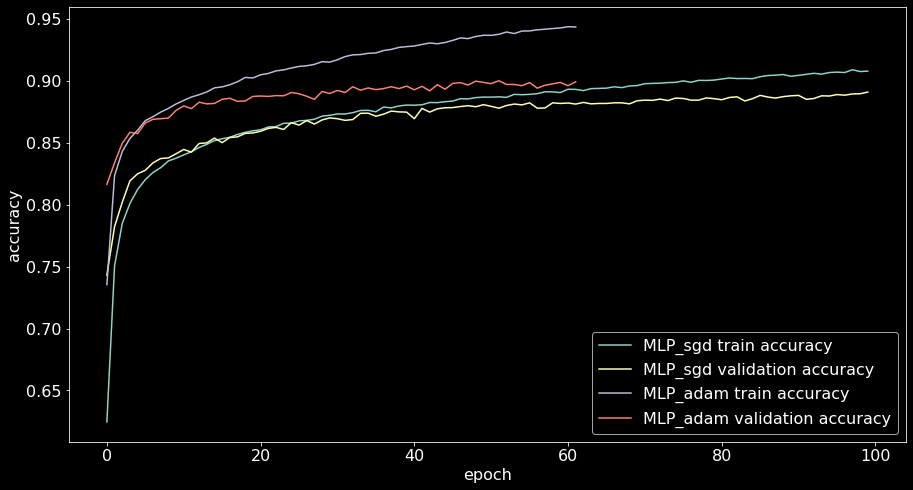

In [ ]:
viz_history(hs_dict={'MLP_sgd':tuned_mlp_sgd_hs,'MLP_adam':tuned_hs},metric='accuracy')

### Model Assesment

In [ ]:
import pandas as pd

In [ ]:
predictions=tuned_mlp_model.predict(X_test)
predicted_classes=np.argmax(predictions,axis=1)

In [ ]:


p = predicted_classes[:10000]
y = test_labels[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]



In [ ]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 8959
Incorrect predicted classes: 1041


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

In [ ]:
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

In [ ]:
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(10)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.85      0.85      0.85      1000
    Class 1 (Trouser) :       0.99      0.97      0.98      1000
   Class 2 (Pullover) :       0.83      0.80      0.81      1000
      Class 3 (Dress) :       0.87      0.92      0.89      1000
       Class 4 (Coat) :       0.82      0.83      0.82      1000
     Class 5 (Sandal) :       0.98      0.96      0.97      1000
      Class 6 (Shirt) :       0.73      0.73      0.73      1000
    Class 7 (Sneaker) :       0.94      0.96      0.95      1000
        Class 8 (Bag) :       0.98      0.97      0.97      1000
 Class 9 (Ankle Boot) :       0.96      0.96      0.96      1000

               accuracy                           0.90     10000
              macro avg       0.90      0.90      0.90     10000
           weighted avg       0.90      0.90      0.90     10000





The best accuracy is obtained for Class 1, Class 5, Class 8, Class 9 and Class 7. Worst accuracy is for Class 6.

The recall is highest for Class 1, Class 5 and smallest for Class 6 and Class 2.

f1-score is highest for Class 1, Class 5 and Class 8 and smallest for Class 6 followed by Class 4 and Class 2.





In [ ]:
cm=confusion_matrix(test_labels,predicted_classes)
cm2df(cm, labels.values())

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle Boot
T-shirt/top,851,1,16,25,3,1,92,0,11,0
Trouser,1,970,1,22,3,0,3,0,0,0
Pullover,18,0,798,10,100,0,74,0,0,0
Dress,16,3,11,918,17,0,29,0,6,0
Coat,0,1,67,40,829,0,63,0,0,0
Sandal,0,0,0,1,0,964,0,22,1,12
Shirt,105,0,70,33,54,0,734,0,4,0
Sneaker,0,0,0,0,0,12,0,964,0,24
Bag,5,0,4,5,4,3,4,6,969,0
Ankle Boot,0,0,0,0,0,7,1,30,0,962


We can see that the Shirt which has the lowest accuracy is mostly confused with the T-shirt/top,the Pullover and the Dress. Also the pullover is mostly confused with the Coat 